In [249]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import os
import glob
import numpy as np
import gzip as gz
import pickle
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, random_split

In [250]:
###### Set the device to use Apple M1 GPU #######
device_GPU = th.device('mps')

# GAN implementation : comparison between spectrum and time serie 
https://towardsdatascience.com/synthetic-time-series-data-a-gan-approach-869a984f2239

In [251]:
data_path = '/Users/martinblot/Desktop/sleep-edf-prepared/5-cassette'  ## path towards the 5-cassette file which is the only one we use here
fp = gz.open(data_path+'/SC4001E0.npz.gz','rb')
data_test = np.load(fp,allow_pickle=True)
fnames = glob.glob(os.path.join(data_path, "*npz.gz"))
devpart = 10
xtrain , xvalid = None , None
ytrain , yvalid = None , None
measurement=data_test['ch_label'][2]

for fn in tqdm(fnames):
    fp = gz.open(fn,'rb')
    data = np.load(fp,allow_pickle=False) # for now, don't care about headers
    x = data['x'][:,:,2] # onlye EOG
    y = data['y'] # Take the labels
    idx = np.arange(x.shape[0]) 
    np.random.shuffle(idx)  
    devlim = x.shape[0]//devpart
    devpart = 10
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    devlim = x.shape[0]//devpart
    if xtrain is None:
        xtrain = np.zeros((1,x.shape[1]))    ##np.zeros((1,x.shape[1],2)) if we include EOG  
        xvalid = np.zeros((1,x.shape[1]))
        ytrain , yvalid = np.zeros(1) , np.zeros(1)
    xvalid = np.concatenate((xvalid,x[idx[:devlim]]), axis=0)
    yvalid = np.concatenate((yvalid,y[idx[:devlim]]), axis=0)
    xtrain = np.concatenate((xtrain,x[idx[devlim:]]), axis=0)
    ytrain = np.concatenate((ytrain,y[idx[devlim:]]), axis=0)
    del x,y

xtrain , xvalid = xtrain[1:] , xvalid[1:]
ytrain , yvalid = ytrain[1:] , yvalid[1:]
xtrain, xvalid = th.FloatTensor(xtrain), th.FloatTensor(xvalid)
ytrain, yvalid = th.IntTensor(ytrain), th.IntTensor(yvalid)

100%|██████████| 153/153 [01:03<00:00,  2.43it/s]


In [253]:
outf="/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck"
fp = open(outf,"wb")
pickle.dump((xtrain , xvalid , ytrain , yvalid), fp)
filepath = '/Users/martinblot/Desktop/sleep-edf-prepared/cassette-th-data-all.pck'
xtrain,xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
print(xtrain.shape)

torch.Size([175995, 600])


In [302]:
batch=100
N=1000

label_mask=np.zeros_like(ytrain[:N])
label_mask[0:25]=1
label_mask_tensor=th.tensor(label_mask)
xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:N]),th.tensor(ytrain[:N])
xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:10000]),th.tensor(yvalid[:10000])

dataset_t = TensorDataset(xtrain_tensor, ytrain_tensor, label_mask_tensor)
train_loader = DataLoader(dataset_t, batch_size= batch, shuffle=True)
dataset_v = TensorDataset(xvalid_tensor, yvalid_tensor)
valid_loader = DataLoader(dataset_v, batch_size= batch, shuffle=True)

/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_53208/182583778.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xtrain_tensor,ytrain_tensor=th.tensor(xtrain[:N]),th.tensor(ytrain[:N])
/var/folders/4d/0mw5kdt55tl7r35rc_2wqkph0000gn/T/ipykernel_53208/182583778.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xvalid_tensor,yvalid_tensor=th.tensor(xvalid[:10000]),th.tensor(yvalid[:10000])


In [303]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, output_dim, n_layers):
        super(Generator, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_dim= output_dim
        self.GRU = nn.GRU(1, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)  
        self.gen_block = nn.Linear(2*hidden_dim, output_dim)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x=x.unsqueeze(-1) #to have a feature=1 (EOG) for an input of size (batch, seq_len, feature)
        x, _ = self.GRU(x)
        x = x[:, -1]# Prendre seulement la sortie du dernier pas de temps
        x = self.gen_block(x)
        x = self.activation(x)
        return x
    
class Discriminator(nn.Module):
    def __init__(self, hidden_dim, n_layers, num_classes):
        super(Discriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.num_classes = num_classes
        self.GRU = nn.GRU(1, hidden_dim, num_layers=n_layers, batch_first=True, bidirectional=True)
        self.dis_block = nn.Linear(2 * hidden_dim, 1) #discrimination
        self.activation = nn.Sigmoid()
        self.class_block = nn.Linear(2 * hidden_dim, num_classes) #classification
    
    def forward(self, x):
        x = x.unsqueeze(-1)
        x, _ = self.GRU(x)
        x = x[:, -1]
        dis_output = self.dis_block(x)
        dis_output = self.activation(dis_output)
        class_logits = self.class_block(x)
        gan_logits = th.logsumexp(class_logits, 1)
        features = x  # Utilisation de la sortie avant la dernière couche linéaire
        return dis_output, class_logits, gan_logits, features


In [304]:
def compute_loss(fake_output, fake_labels, real_output, real_batch_labels, gen_criterion, dis_criterion, class_logits, labels, label_mask_tensor, supervised_criterion=nn.CrossEntropyLoss()):
    gloss = gen_criterion(fake_output, real_batch_labels)
    unsupervised_loss = dis_criterion(real_output, real_batch_labels)+dis_criterion(fake_output, fake_labels)
    supervised_loss = supervised_criterion(class_logits, labels.long())    
    label_mask=th.squeeze(label_mask_tensor)
    supervised_loss = th.sum(th.mul(supervised_loss, label_mask))
    supervised_loss = supervised_loss / th.max(th.tensor(1.0), th.sum(label_mask))
    dloss=supervised_loss+unsupervised_loss
    correct, masked_correct = 0,0
    
    eq = th.eq(th.squeeze(labels), th.argmax(class_logits, dim=1))
    
    masked_correct = th.sum(label_mask * eq.float()).item()  # Compute the number of correct predictions considering only the labeled data
    
    correct = th.sum(eq.float()).item()   # Compute the number of correct predictions considering all data, both labeled and unlabeled

    
    return gloss,dloss,correct,masked_correct  # mask_correct if needed to compute the training loss


https://github.com/ydataai/ydata-synthetic/blob/dev/src/ydata_synthetic/synthesizers/timeseries/timegan/model.py

In [305]:
def train_GAN(discriminator, generator, batch, trainloader, validloader, hidden_dim, dis_loss, gen_loss, lr=0.0002, nepoch=10, device='cpu'):
    real_batch_labels = th.ones((batch, 1)).to(device)
    fake_batch_labels = th.zeros((batch, 1)).to(device)
    optim_generator = optim.Adam(generator.parameters(), lr=lr)
    optim_discriminator = optim.Adam(discriminator.parameters(), lr=lr)
    g_losses, d_losses, val_accuracies= [], [], []
    for epoch in tqdm(range(nepoch)):
        running_d_loss = 0
        running_g_loss = 0
        val_correct = 0
        total_samples = 0  # Total number of samples, including both labeled and unlabeled
        total_samples_val=0
        for inputs, labels, labels_mask in trainloader:
            z = th.randn((batch, hidden_dim))
            h = generator(z)
            fake_outputs, _, _, _ = discriminator(h)
            outputs, class_logits, _, _ = discriminator(inputs)
            outputs, class_logits = outputs.to(device), class_logits.to(device)
            g_loss, d_loss, _ , _ = compute_loss(fake_outputs, fake_batch_labels, outputs, real_batch_labels, gen_loss, dis_loss, class_logits, labels, labels_mask)
            optim_discriminator.zero_grad()
            optim_generator.zero_grad()
            d_loss.backward(retain_graph=True)
            g_loss.backward()
            optim_discriminator.step()
            optim_generator.step()

            running_d_loss += d_loss.item()
            running_g_loss += g_loss.item()
            total_samples += labels.size(0)  # Add the number of samples in the current batch to the total

        g_losses.append(running_g_loss / len(trainloader))
        d_losses.append(running_d_loss / len(trainloader))

        for inputs_val, labels_val in validloader:
            z = th.randn((batch, hidden_dim))
            h = generator(z)
            fake_outputs, _, _, _ = discriminator(h)
            outputs, class_logits, _, _ = discriminator(inputs_val)
            _,_,correct,_  = compute_loss(fake_outputs, fake_batch_labels, outputs, real_batch_labels, gen_loss, dis_loss, class_logits, labels, labels_mask)
            optim_discriminator.zero_grad()
            optim_generator.zero_grad()
            optim_discriminator.step()
            optim_generator.step()

            val_correct+=correct
            total_samples_val += labels_val.size(0)

        val_accuracy=val_correct / total_samples_val
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{nepoch} -> "
              f"Generator Loss: {running_g_loss:.4f}, "
              f"Discriminator Loss: {running_d_loss:.4f}, "
              f"Validation accuracy : {val_accuracy:.4f}")

    return g_losses, d_losses, val_accuracies


In [310]:
learning_rate=0.001
hidden_dim = 32
num_epochs = 30
input_dim=600
n_layers=2

generator = Generator(hidden_dim, input_dim, n_layers)
discriminator = Discriminator(hidden_dim,n_layers,5)

bceloss=nn.BCELoss()

g_losses, d_losses, val_accuracies=train_GAN(discriminator, generator, batch, train_loader, valid_loader, hidden_dim, bceloss, bceloss, lr = learning_rate, nepoch = num_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [01:59<57:38, 119.25s/it]

Epoch 1/30 -> Generator Loss: 6.7747, Discriminator Loss: 27.0804, Validation accuracy : 0.4352


  7%|▋         | 2/30 [04:19<1:01:21, 131.49s/it]

Epoch 2/30 -> Generator Loss: 5.9618, Discriminator Loss: 25.3710, Validation accuracy : 0.4185


 10%|█         | 3/30 [06:29<58:53, 130.86s/it]  

Epoch 3/30 -> Generator Loss: 5.2315, Discriminator Loss: 21.7903, Validation accuracy : 0.5195


 13%|█▎        | 4/30 [08:39<56:31, 130.45s/it]

Epoch 4/30 -> Generator Loss: 5.9283, Discriminator Loss: 18.9877, Validation accuracy : 0.3985


 17%|█▋        | 5/30 [10:34<52:02, 124.88s/it]

Epoch 5/30 -> Generator Loss: 7.3906, Discriminator Loss: 16.4881, Validation accuracy : 0.4826


 20%|██        | 6/30 [12:34<49:15, 123.14s/it]

Epoch 6/30 -> Generator Loss: 6.6576, Discriminator Loss: 15.4504, Validation accuracy : 0.4770


 23%|██▎       | 7/30 [14:26<45:53, 119.71s/it]

Epoch 7/30 -> Generator Loss: 7.1112, Discriminator Loss: 16.5157, Validation accuracy : 0.4544


 23%|██▎       | 7/30 [16:42<54:52, 143.17s/it]


KeyboardInterrupt: 

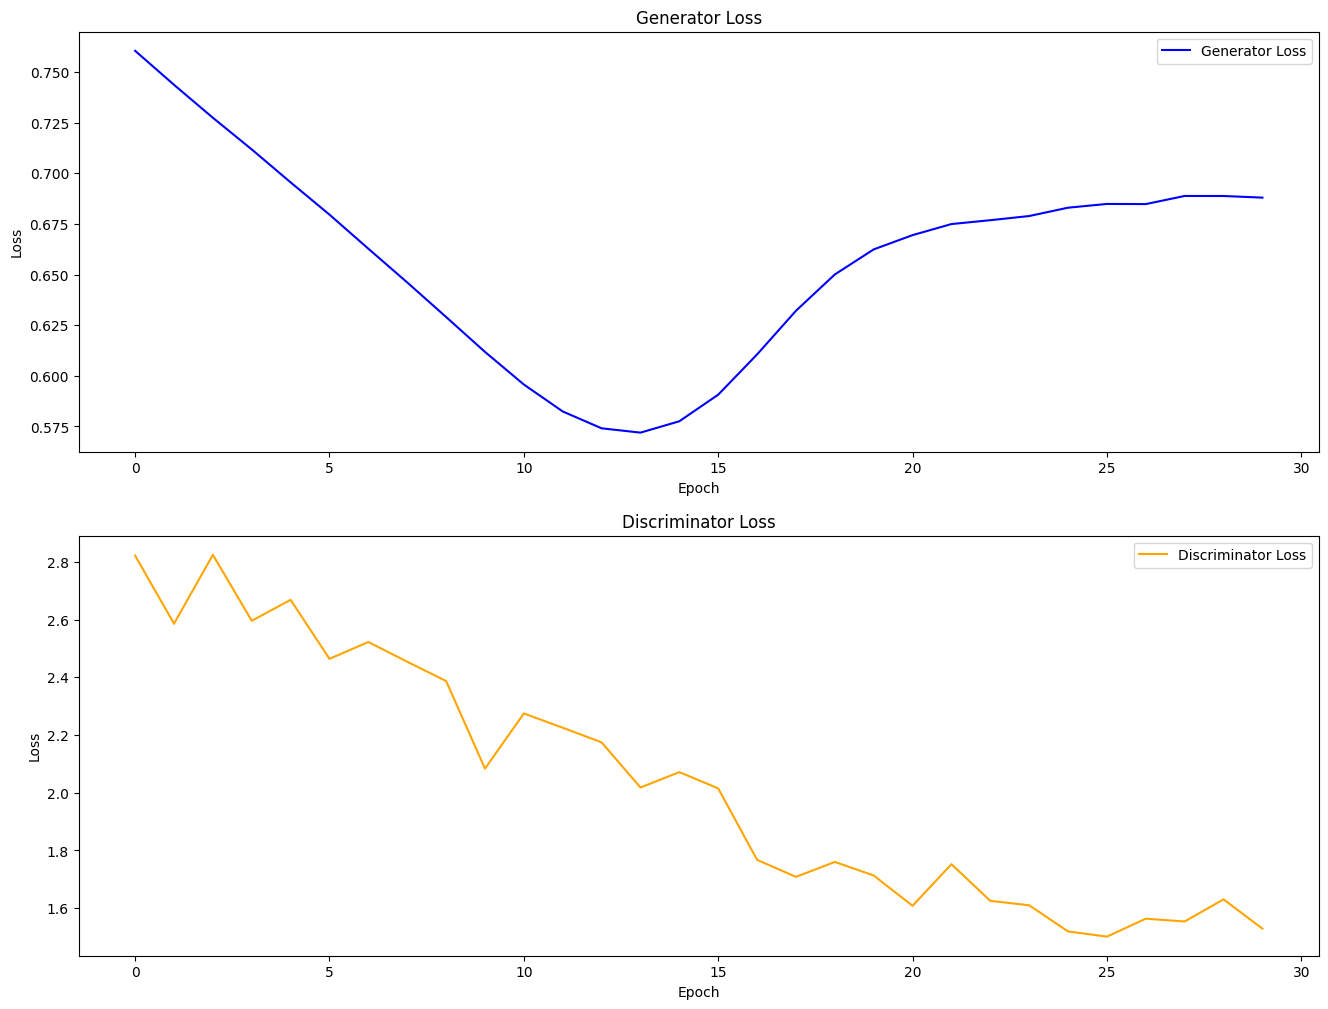

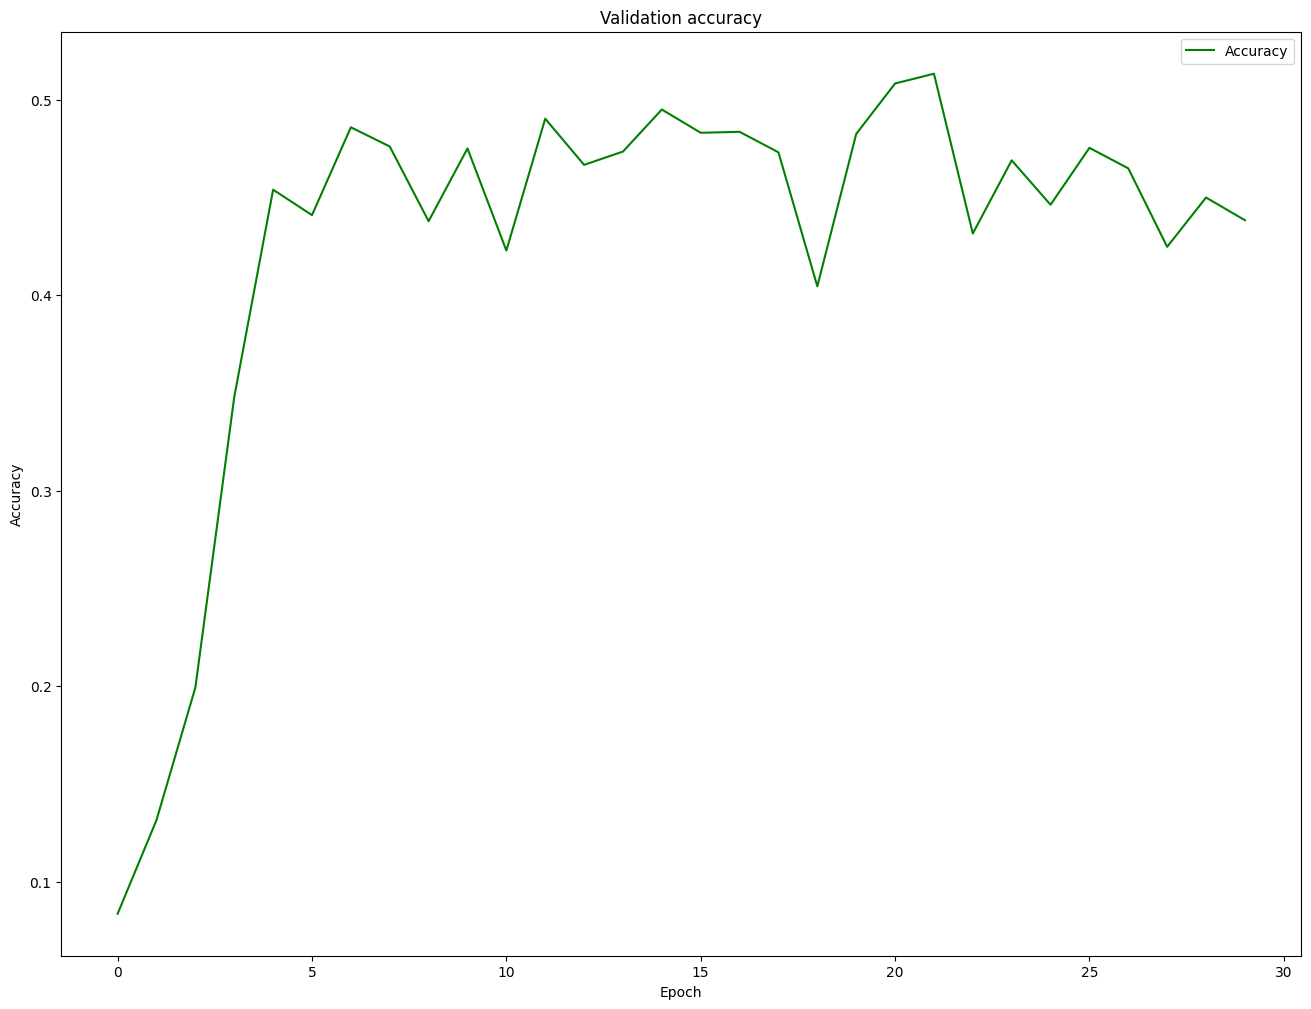

In [309]:
plt.figure(figsize=(16, 12))
plt.subplot(2, 1, 1)
plt.plot(g_losses, label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(d_losses, label='Discriminator Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()
plt.show()

plt.figure(figsize=(16, 12))
plt.plot(val_accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation accuracy')
plt.legend()
plt.show()
